# GRU4Rec: Sequential Recommendation with Gated Recurrent Units

## 1. Introduction & Theory (The "Why")

### 1.1 Academic Context: Why Recurrent Neural Networks for Recommendation?

In traditional recommendation systems, we treat user preferences as static profiles. But **user behavior is temporal** - what a user clicked 5 minutes ago is more relevant than what they clicked 5 weeks ago.

**GRU4Rec (Session-based Recommendations with Recurrent Neural Networks)** treats user histories as sequential data:
- **Items = Words/Tokens** in a vocabulary
- **User History = Sentence** to be "understood"
- **Next-Item Prediction = Language Model** predicting the next word

This notebook serves as the **foundational prerequisite** to understand sequential processing before graduating to parallel processing (Transformers) in `sequential_recommender.ipynb`.

### 1.2 Core Concepts

#### Recurrent Neural Networks (RNN)

Traditional feedforward networks treat each input independently. RNNs introduce **temporal dependencies** by maintaining a **hidden state** that carries information from previous time steps.

The fundamental RNN update equation:

$$h_t = tanh(W_hh * h_{t-1} + W_xh * x_t + b)$$

Where:
- $h_t$: Hidden state at time step t
- $x_t$: Input at time step t
- $W_hh$: Hidden-to-hidden weight matrix
- $W_xh$: Input-to-hidden weight matrix

#### The Vanishing Gradient Problem

**The Problem**: Standard RNNs struggle to learn long-range dependencies.

During backpropagation through time (BPTT), gradients are multiplied repeatedly by the weight matrix. When these values are < 1, gradients shrink exponentially:


$$∂h_t/∂h_0 = ∏(i=1 to t) ∂h_i/∂h_{i-1} → 0 (exponentially fast)$$

This means early events in a sequence have negligible influence on later predictions—the network "forgets" early history.

#### The Solution: Gated Recurrent Unit (GRU)

GRU addresses the vanishing gradient problem through **gating mechanisms** that allow the network to learn **when to update** and **when to preserve** hidden state information.

**The Update Gate ($z_t$)**: "Decides how much past memory to keep."
$$z_t = σ(W_z · [h_{t-1}, x_t])$$
- When $z_t ≈ 1$: Keep past state (bypass new input)
- When $z_t ≈ 0$: Update with new information

**The Reset Gate ($r_t$)**: "Decides how much past memory to ignore."
$$
r_t = σ(W_r · [h_{t-1}, x_t])
$$
- When $r_t ≈ 0$: Ignore past state completely (fresh start)
- When $r_t ≈ 1$: Use full past context

**The Candidate Hidden State ($\tilde{h}_t$)**:
$$
h̃_t = tanh(W · [r_t ⊙ h_{t-1}, x_t])
$$

**The Final Hidden State ($h_t$)**:
$$
h_t = (1 - z_t) ⊙ h_{t-1} + z_t ⊙ h̃_t
$$

This creates a "highway" where gradients can flow unimpeded when $z_t ≈ 0$, solving the vanishing gradient problem for moderate sequence lengths.

### 1.3 Business Value

1. **Discovery**: Recommend items users wouldn't explicitly search for, but might find interesting based on their behavioral patterns.

2. **Cross-Selling**: Bridge Retail (FMCG) and Marketplace domains. A user buying baby formula → suggest strollers from Marketplace.

3. **Session Awareness**: Capture "in-session intent" - if a user views 3 laptops in a row, they're laptop shopping NOW.

---
## 2. Configuration & Imports

We configure all hyperparameters upfront with memory-conscious defaults for Colab.
We use the **same hyperparameters as SASRec** for fair comparison.

In [1]:
# Install dependencies if needed (uncomment in Colab)
# !pip install torch pandas numpy matplotlib seaborn tqdm\n

import os
import gc
import warnings
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

# Configuration
CLEANED_DATA_DIR = "cleaned_data"
EMBEDDINGS_DIR = "models/item_embeddings"
OUTPUT_DIR = "models/gru_recommender"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Hyperparameters (Identical to SASRec for fair comparison)
MAX_SEQ_LENGTH = 50       # Covers 95th percentile of sequence lengths
EMBEDDING_DIM = 128       # Match pre-trained embeddings
HIDDEN_DIM = 256          # GRU hidden dimension
DROPOUT = 0.1
BATCH_SIZE = 512          # Memory-friendly
LEARNING_RATE = 1e-3
NUM_EPOCHS = 3            # Sufficient for demonstration
SEED = 42

# Clear everything
torch.cuda.empty_cache()
gc.collect()

# Set random seeds for reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 4070 Laptop GPU
GPU Memory: 8.6 GB


---
## 3. Data Preparation (Model-Agnostic)

### Teaching Point: Data Preparation is Model-Agnostic

Whether we use an RNN (GRU) or a Transformer (SASRec), the input data (Sequence of IDs) remains **identical**. This is a fundamental principle in sequential recommendation:

- **Input**: Ordered list of item indices representing user's interaction history
- **Target**: The next item the user will interact with

### Memory Optimization Strategies:
1. **int32 for IDs**: Saves 50% RAM compared to int64
2. **Load only required columns**: Skip `action_type`, `subdomain`, `os`
3. **Generator-based Dataset**: Build sequences on-demand
4. **Sequence length cap**: Truncate to 50 items

In [2]:
def load_and_prepare_data():
    """
    Load retail and marketplace events, map to vocabulary indices.
    
    Memory-Optimized Implementation:
    - Load only required columns (user_id, item_id, timestamp)
    - Use int32 for indices (saves 50% memory)
    - Remove unmapped items immediately
    """
    print("=" * 60)
    print("LOADING DATA")
    print("=" * 60)
    
    # 1. Load Item Vocabulary (from item_embeddings.ipynb)
    print("\n1. Loading item vocabulary...")
    vocab_path = os.path.join(EMBEDDINGS_DIR, "item_vocabulary.parquet")
    vocab_df = pd.read_parquet(vocab_path)
    
    # Create mapping dictionaries
    # IMPORTANT: Shift indices by 1 because 0 is reserved for padding
    item_to_idx = {item: idx + 1 for item, idx in zip(vocab_df['item_id'], vocab_df['index'])}
    idx_to_item = {idx: item for item, idx in item_to_idx.items()}
    vocab_size = len(item_to_idx) + 1  # +1 for padding token at index 0
    
    print(f"   Vocabulary size: {vocab_size:,} items (including padding)")
    
    # 2. Load Events (only required columns)
    print("\n2. Loading event streams...")
    
    # Retail Events
    retail_path = os.path.join(CLEANED_DATA_DIR, "retail_events_clean.parquet")
    retail = pd.read_parquet(retail_path, columns=['user_id', 'item_id', 'timestamp'])
    print(f"   Retail events: {len(retail):,}")
    
    # Marketplace Events  
    marketplace_path = os.path.join(CLEANED_DATA_DIR, "marketplace_events_clean.parquet")
    marketplace = pd.read_parquet(marketplace_path, columns=['user_id', 'item_id', 'timestamp'])
    print(f"   Marketplace events: {len(marketplace):,}")
    
    # 3. Combine and sort
    print("\n3. Combining and sorting events...")
    events = pd.concat([retail, marketplace], ignore_index=True)
    del retail, marketplace  # Free memory
    gc.collect()
    
    events = events.sort_values(['user_id', 'timestamp'])
    print(f"   Combined events: {len(events):,}")
    
    # 4. Map item_id to vocabulary index
    print("\n4. Mapping items to vocabulary indices...")
    events['item_idx'] = events['item_id'].map(item_to_idx)
    
    # Count how many items couldn't be mapped
    unmapped = events['item_idx'].isna().sum()
    print(f"   Unmapped items (not in vocabulary): {unmapped:,} ({unmapped/len(events)*100:.1f}%)")
    
    # Remove unmapped items and convert to int32
    events = events.dropna(subset=['item_idx'])
    events['item_idx'] = events['item_idx'].astype(np.int32)
    print(f"   Events after filtering: {len(events):,}")
    
    # 5. Build user sequences
    print("\n5. Building user sequences...")
    user_sequences = events.groupby('user_id')['item_idx'].apply(list).to_dict()
    
    # Filter users with at least 2 interactions (minimum for next-item prediction)
    user_sequences = {uid: seq for uid, seq in user_sequences.items() if len(seq) >= 2}
    print(f"   Users with >=2 events: {len(user_sequences):,}")
    
    # Sequence length statistics
    seq_lengths = [len(seq) for seq in user_sequences.values()]
    print(f"\n   Sequence Length Statistics:")
    print(f"     Min:    {min(seq_lengths)}")
    print(f"     Median: {np.median(seq_lengths):.0f}")
    print(f"     Max:    {max(seq_lengths)}")
    print(f"     Mean:   {np.mean(seq_lengths):.2f}")
    
    del events  # Free memory
    gc.collect()
    
    return user_sequences, item_to_idx, idx_to_item, vocab_size

# Load data
user_sequences, item_to_idx, idx_to_item, vocab_size = load_and_prepare_data()

LOADING DATA

1. Loading item vocabulary...
   Vocabulary size: 456,187 items (including padding)

2. Loading event streams...
   Retail events: 4,128,330
   Marketplace events: 5,081,920

3. Combining and sorting events...
   Combined events: 9,210,250

4. Mapping items to vocabulary indices...
   Unmapped items (not in vocabulary): 1,009,396 (11.0%)
   Events after filtering: 8,200,854

5. Building user sequences...
   Users with >=2 events: 266,371

   Sequence Length Statistics:
     Min:    2
     Median: 8
     Max:    47649
     Mean:   30.71


### 3.1 PyTorch Dataset

We implement a custom Dataset that:
1. **Left-pads** sequences to `MAX_SEQ_LENGTH` (so the last item is always at the same position)
2. Returns `(input_sequence, target_item)` pairs
3. Uses on-demand sequence building (no full tensor in RAM)

In [3]:
class SequenceDataset(Dataset):
    """
    PyTorch Dataset for sequential recommendation.
    
    For each user, we create training samples using sliding window:
    - Input: items[0:i] for i in range(2, len(items)+1)
    - Target: items[i] (next item to predict)
    
    Optimization: We left-pad sequences so that the prediction target
    is always at the last position of the sequence.
    """
    
    def __init__(self, user_sequences: Dict[int, List[int]], max_len: int = MAX_SEQ_LENGTH):
        self.max_len = max_len
        
        # Convert dict to list for efficient indexing
        # self.sequences[i] is the sequence for the i-th user
        self.sequences = list(user_sequences.values())
        
        # Create an index mapping: dataset_idx -> (sequence_idx, target_pos)
        # This avoids storing 9M separate list objects, saving massive RAM
        self.index_map = []
        for seq_idx, seq in enumerate(self.sequences):
            # We predict from position 1 to len-1
            # Input: seq[:i], Target: seq[i]
            for i in range(1, len(seq)):
                self.index_map.append((seq_idx, i))
        
        print(f"Created dataset with {len(self.index_map):,} samples")
    
    def __len__(self):
        return len(self.index_map)
    
    def __getitem__(self, idx):
        seq_idx, target_pos = self.index_map[idx]
        seq = self.sequences[seq_idx]
        
        # Get input sequence (window)
        start_pos = max(0, target_pos - self.max_len)
        input_seq = seq[start_pos:target_pos]
        target = seq[target_pos]
        
        # Left-pad sequence to max_len (pad with 0, which we'll use as padding idx)
        # This ensures the most recent item is always at the last position
        pad_len = self.max_len - len(input_seq)
        padded = [0] * pad_len + input_seq
        
        return torch.tensor(padded, dtype=torch.long), torch.tensor(target, dtype=torch.long)


def create_data_splits(user_sequences: Dict[int, List[int]], 
                       train_ratio=0.8, val_ratio=0.1):
    """
    Split users into train/val/test sets.
    
    We split by USER (not by sample) to avoid data leakage:
    - User A's sequences should not appear in both train and test
    """
    user_ids = list(user_sequences.keys())
    np.random.shuffle(user_ids)
    
    n_users = len(user_ids)
    train_end = int(n_users * train_ratio)
    val_end = int(n_users * (train_ratio + val_ratio))
    
    train_users = set(user_ids[:train_end])
    val_users = set(user_ids[train_end:val_end])
    test_users = set(user_ids[val_end:])
    
    train_seqs = {uid: seq for uid, seq in user_sequences.items() if uid in train_users}
    val_seqs = {uid: seq for uid, seq in user_sequences.items() if uid in val_users}
    test_seqs = {uid: seq for uid, seq in user_sequences.items() if uid in test_users}
    
    print(f"\nData splits:")
    print(f"  Train: {len(train_seqs):,} users")
    print(f"  Val:   {len(val_seqs):,} users")
    print(f"  Test:  {len(test_seqs):,} users")
    
    return train_seqs, val_seqs, test_seqs


# Create data splits
train_seqs, val_seqs, test_seqs = create_data_splits(user_sequences)

# Create datasets
train_dataset = SequenceDataset(train_seqs)
val_dataset = SequenceDataset(val_seqs)
test_dataset = SequenceDataset(test_seqs)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(f"\nData loaders created:")
print(f"  Train batches: {len(train_loader):,}")
print(f"  Val batches:   {len(val_loader):,}")
print(f"  Test batches:  {len(test_loader):,}")


Data splits:
  Train: 213,096 users
  Val:   26,637 users
  Test:  26,638 users
Created dataset with 6,385,368 samples
Created dataset with 793,053 samples
Created dataset with 736,659 samples

Data loaders created:
  Train batches: 12,472
  Val batches:   1,549
  Test batches:  1,439


---
## 4. Model Architecture (The Core Difference)

### GRU4Rec Architecture

This is where GRU differs fundamentally from SASRec (Transformer):

```
Input Sequence [batch, seq_len]
        ↓
Item Embedding
        ↓
GRU (Processes Sequentially: t=0 → t=1 → ... → t=n)
        ↓           ↑
    [Hidden State h_t passes to h_{t+1}]
        ↓
Take LAST Output → [batch, hidden_dim]
        ↓
Linear Projection → [batch, vocab_size]
```

### Key Architectural Differences from SASRec:

| Aspect | GRU4Rec (This Notebook) | SASRec (Transformers) |
|--------|------------------------|----------------------|
| **Processing** | Sequential (t-1 must finish before t) | Parallel (all positions at once) |
| **Position Encoding** | Implicit via hidden state | Explicit position embeddings |
| **Attention** | None (hidden state aggregates context) | Self-attention to all past positions |
| **Memory of Past** | Compressed into fixed-size hidden state | Direct access to all past representations |

### Why Use Only the Last Output?

The GRU processes the sequence step-by-step. At each time step $t$, the hidden state $h_t$ contains a **compressed representation** of all items seen so far $[x_0, x_1, ..., x_t]$.

For next-item prediction, we only care about predicting what comes **after** the entire input sequence. Therefore, we use $h_{T-1}$ (the last hidden state), which contains the model's understanding of the complete user history.

In [4]:
def load_pretrained_embeddings(vocab_size: int, embed_dim: int):
    """
    Load pre-trained item embeddings from item_embeddings.ipynb.
    
    Returns a numpy array of shape [vocab_size, embed_dim].
    If embeddings file doesn't exist, returns randomly initialized weights.
    """
    emb_path = os.path.join(EMBEDDINGS_DIR, "item_embeddings.parquet")
    
    if os.path.exists(emb_path):
        print("Loading pre-trained embeddings...")
        emb_df = pd.read_parquet(emb_path)
        
        # Stack embeddings into matrix
        pretrained = np.vstack(emb_df['embedding'].values)
        print(f"  Loaded embeddings: {pretrained.shape}")
        
        # Verify dimensions match
        if pretrained.shape[1] != embed_dim:
            print(f"  Warning: Embedding dim mismatch ({pretrained.shape[1]} vs {embed_dim})")
            print("  Using random initialization instead.")
            return None
        
        # Create new embedding matrix with padding at index 0
        # Shape: [vocab_size, embed_dim] where vocab_size includes padding
        embeddings = np.zeros((vocab_size, embed_dim))
        
        # Copy pretrained weights to indices 1..N
        # We assume the order in item_embeddings.parquet matches item_vocabulary.parquet
        # (which is true based on item_embeddings.ipynb logic)
        n_pretrained = pretrained.shape[0]
        n_vocab_items = vocab_size - 1
        
        n_copy = min(n_pretrained, n_vocab_items)
        embeddings[1:n_copy+1] = pretrained[:n_copy]
        
        return embeddings
    else:
        print(f"  Pre-trained embeddings not found at {emb_path}")
        print("  Using random initialization.")
        return None


class GRURecommender(nn.Module):
    """
    GRU4Rec: Session-based Recommendations with Recurrent Neural Networks.
    
    Paper: "Session-based Recommendations with Recurrent Neural Networks" 
           (Hidasi et al., ICLR 2016)
    
    Architecture:
    - Item Embedding (optionally pre-trained)
    - GRU Layer (processes sequence step-by-step)
    - Linear Prediction Head
    
    Args:
        vocab_size: Number of items in vocabulary
        embed_dim: Embedding dimension
        hidden_dim: GRU hidden state dimension
        dropout: Dropout rate
        pretrained_emb: Optional pre-trained embedding weights
    """
    
    def __init__(self, vocab_size: int, embed_dim: int = 128, hidden_dim: int = 256,
                 dropout: float = 0.1, pretrained_emb: Optional[np.ndarray] = None):
        super().__init__()
        
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        
        # Component 1: Item Embedding (with padding_idx=0)
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        # Initialize with pre-trained weights if available
        if pretrained_emb is not None:
            self.embedding.weight.data.copy_(torch.tensor(pretrained_emb, dtype=torch.float32))
            print(f"  Initialized item embeddings with pre-trained weights")
        
        # Component 2: GRU Layer
        # input_size: dimension of input at each time step (embed_dim)
        # hidden_size: dimension of hidden state
        # batch_first: input shape is [batch, seq_len, features]
        self.gru = nn.GRU(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            batch_first=True,
            dropout=dropout if dropout > 0 else 0
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Component 3: Prediction Head
        # Maps hidden state back to vocabulary space for next-item prediction
        self.head = nn.Linear(hidden_dim, vocab_size)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize GRU and FC layer weights."""
        for name, param in self.gru.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
        nn.init.xavier_uniform_(self.head.weight)
        nn.init.zeros_(self.head.bias)
    
    def forward(self, seq: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.
        
        Args:
            seq: [batch, seq_len] - Item indices (0 = padding)
            
        Returns:
            logits: [batch, vocab_size] - Prediction logits for next item
        """
        batch_size, seq_len = seq.shape
        
        # Step 1: Embed items
        # embeds shape: [batch, seq_len, embed_dim]
        embeds = self.embedding(seq)
        embeds = self.dropout(embeds)
        
        # Step 2: Process through GRU
        # output shape: [batch, seq_len, hidden_dim] - output at each time step
        # hidden shape: [1, batch, hidden_dim] - final hidden state
        output, hidden = self.gru(embeds)
        
        # Step 3: CRUCIAL - Take only the LAST time step's output
        # Why? The hidden state at position t contains the compressed representation
        # of all items seen up to t. For next-item prediction, we need the state
        # after seeing ALL input items, which is at the last position.
        last_output = output[:, -1, :]  # [batch, hidden_dim]
        
        # Step 4: Project to vocabulary space
        logits = self.head(last_output)  # [batch, vocab_size]
        
        return logits
    
    def predict(self, seq: torch.Tensor, k: int = 10) -> torch.Tensor:
        """
        Predict top-k next items.
        
        Args:
            seq: [batch, seq_len] - Item indices
            k: Number of top items to return
            
        Returns:
            top_k_items: [batch, k] - Top-k predicted item indices
        """
        self.eval()
        with torch.no_grad():
            logits = self.forward(seq)  # [batch, vocab_size]
            # Get top-k
            _, top_k = torch.topk(logits, k, dim=1)
        return top_k


# Load pre-trained embeddings
pretrained_emb = load_pretrained_embeddings(vocab_size, EMBEDDING_DIM)

# Create model
model = GRURecommender(
    vocab_size=vocab_size,
    embed_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    dropout=DROPOUT,
    pretrained_emb=pretrained_emb
).to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Summary:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Estimated size: {total_params * 4 / 1e6:.1f} MB (float32)")

Loading pre-trained embeddings...
  Loaded embeddings: (456186, 128)
  Initialized item embeddings with pre-trained weights

Model Summary:
  Total parameters: 175,928,443
  Trainable parameters: 175,928,443
  Estimated size: 703.7 MB (float32)


---
## 5. Training & Evaluation

We use the **same training loop and evaluation functions as SASRec** to enable fair comparison.

### Training Strategy:
1. **Loss**: CrossEntropyLoss (standard for multi-class classification)
2. **Optimizer**: AdamW (Adam with weight decay)
3. **Learning Rate**: 1e-3 with ReduceLROnPlateau scheduler
4. **Memory Monitoring**: Print GPU usage every 1000 batches

In [5]:
from torch.cuda.amp import GradScaler, autocast

# Initialize scaler (add this near the optimizer setup)
scaler = GradScaler()

def calculate_accuracy(logits, targets):
    """Calculate accuracy, ignoring any padding if present."""
    preds = torch.argmax(logits, dim=-1)
    correct = (preds == targets).sum().item()
    total = targets.numel()
    return correct, total

def train_epoch(model, train_loader, optimizer, device, scaler):
    """Train for one epoch with Automatic Mixed Precision."""
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    num_batches = 0
    
    pbar = tqdm(train_loader, desc="Training", leave=False)
    for batch_idx, (seq, target) in enumerate(pbar):
        seq = seq.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)
        
        # Forward pass with AMP
        with autocast():
            logits = model(seq)
            loss = F.cross_entropy(logits, target)
        
        # Backward pass with scaled gradients
        optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
        scaler.scale(loss).backward()
        
        # Gradient clipping (unscale first)
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        
        # Calculate Accuracy
        with torch.no_grad():
            correct, total = calculate_accuracy(logits, target)
            total_correct += correct
            total_samples += total
        
        num_batches += 1
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / num_batches
    avg_acc = total_correct / total_samples if total_samples > 0 else 0
    return avg_loss, avg_acc


def evaluate(model, data_loader, device):
    """Evaluate model on validation/test set."""
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    num_batches = 0
    
    with torch.no_grad():
        for seq, target in tqdm(data_loader, desc="Evaluating", leave=False):
            seq = seq.to(device)
            target = target.to(device)
            
            logits = model(seq)
            loss = F.cross_entropy(logits, target)
            
            total_loss += loss.item()
            
            # Calculate Accuracy
            correct, total = calculate_accuracy(logits, target)
            total_correct += correct
            total_samples += total
            
            num_batches += 1
    
    avg_loss = total_loss / num_batches
    avg_acc = total_correct / total_samples if total_samples > 0 else 0
    return avg_loss, avg_acc


# Training setup
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

# Training history - NOW INCLUDES ACCURACY
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_loss = float('inf')

print("\n" + "=" * 60)
print("TRAINING")
print("=" * 60)
print(f"Epochs: {NUM_EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print()

# Before the epoch loop
scaler = GradScaler()

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, scaler)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    
    # Validate
    val_loss, val_acc = evaluate(model, val_loader, device)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Learning rate scheduling
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_model.pt'))
        saved_marker = " (saved)"
    else:
        saved_marker = ""
    
    # Print summary
    lr_change = f" [lr: {old_lr:.6f} → {new_lr:.6f}]" if old_lr != new_lr else ""
    print(f"  Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Acc: {val_acc:.4f}{lr_change}{saved_marker}")
    
    # GPU memory
    if torch.cuda.is_available():
        print(f"  GPU Memory: {torch.cuda.memory_allocated() / 1e9:.2f}GB / {torch.cuda.max_memory_allocated() / 1e9:.2f}GB (peak)")
    print()

print(f"Best validation loss: {best_val_loss:.4f}")


TRAINING
Epochs: 3
Batch size: 512
Learning rate: 0.001

Epoch 1/3


  Train Loss: 6.8681 | Acc: 0.0337
  Val Loss:   6.8125 | Acc: 0.0379 (saved)
  GPU Memory: 2.84GB / 5.27GB (peak)

Epoch 2/3


  Train Loss: 6.1169 | Acc: 0.0401
  Val Loss:   6.7659 | Acc: 0.0387 (saved)
  GPU Memory: 2.84GB / 5.27GB (peak)

Epoch 3/3


  Train Loss: 5.9171 | Acc: 0.0432
  Val Loss:   6.7850 | Acc: 0.0390
  GPU Memory: 2.84GB / 5.27GB (peak)

Best validation loss: 6.7659


---
## 6. Advanced Statistical Evaluation

While Recommender Systems typically rely on Rank Metrics (HR/NDCG), we can adapt standard classification metrics to diagnose model behavior:

### 1. Statistical Ranking Metrics
* **MRR (Mean Reciprocal Rank):** The "Average Accuracy" of our ranking.
  * *Formula:* $1 / \text{Rank}$. If the correct item is at #1, score is 1.0. If at #10, score is 0.1.
  * *Interpretation:* Indicates how far down the user typically has to scroll to find the result.

### 2. Classification Diagnostics
* **Category Confusion Matrix**: Since an item-level matrix ($450k \times 450k$) is computationally infeasible, we aggregate predictions to the **Category Level** ($20 \times 20$).
  * *Purpose:* Identifies domain confusion (e.g., distinguishing between *Skin Care* and *Makeup*).
---

Building category mapping...
Mapped 168106 items to categories.
Running comprehensive evaluation...


Evaluating: 100%|██████████| 1439/1439 [01:08<00:00, 21.13it/s]



Calculating classification report...


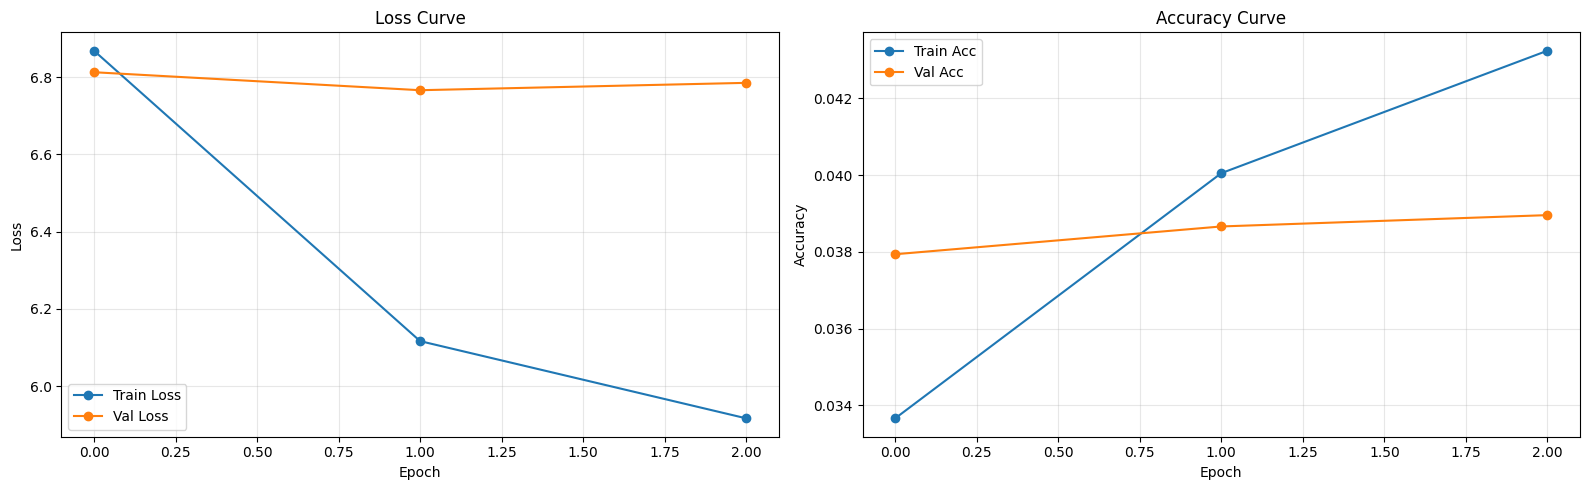

Saved: models/gru_recommender/training_curves.png

MODEL PERFORMANCE SUMMARY


Test Loss:              6.7494
Test Accuracy:          0.0404
Macro Precision:        0.0020
Macro Recall:           0.0040
Macro F1 Score:         0.0017
------------------------------------------------------------
Ranking Metrics:
HR@5:   0.1490
NDCG@5: 0.0952
HR@10:   0.2255
NDCG@10: 0.1199
HR@20:   0.3060
NDCG@20: 0.1402

CLASSIFICATION REPORT (By Category):
              precision    recall  f1-score   support

     Unknown       0.00      0.00      0.00        74
        cart       0.02      0.02      0.02      2603
     catalog       0.74      0.72      0.73    280604
         i2i       0.10      0.08      0.09      5825
        item       0.02      0.02      0.02      2813
        main       0.05      0.07      0.06      7661
       other       0.25      0.30      0.27     72476
      search       0.28      0.19      0.23     76585
         u2i       0.68      0.73      0.70    288018

    accuracy                           0.61    736659
   macro avg       0.24      0.24      

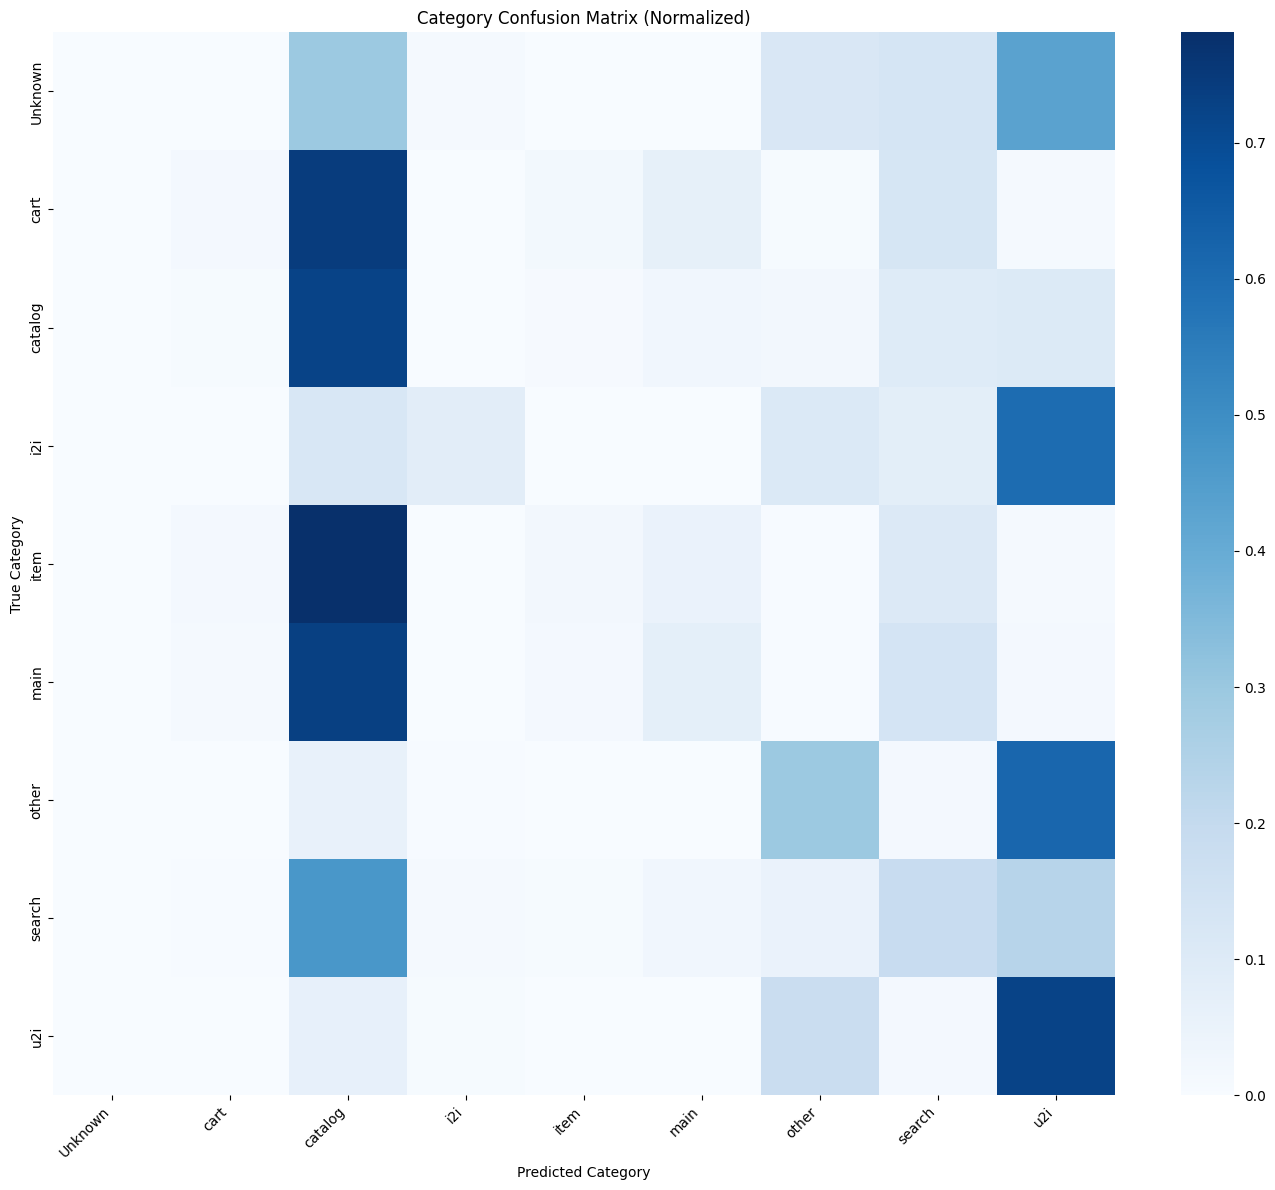

Saved: models/gru_recommender/confusion_matrix.png


In [6]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns

def get_category_mapping(item_to_idx):
    """
    Creates a mapping from vocabulary index to Category (Subdomain).
    """
    print("Building category mapping...")
    # Load raw data to get subdomains
    retail = pd.read_parquet(os.path.join(CLEANED_DATA_DIR, "retail_events_clean.parquet"), columns=['item_id', 'subdomain'])
    marketplace = pd.read_parquet(os.path.join(CLEANED_DATA_DIR, "marketplace_events_clean.parquet"), columns=['item_id', 'subdomain'])
    
    # Combine and drop duplicates
    items = pd.concat([retail, marketplace]).drop_duplicates(subset=['item_id'])
    
    # Create mapping: idx -> subdomain
    idx_to_category = {}
    for _, row in items.iterrows():
        if row['item_id'] in item_to_idx:
            idx = item_to_idx[row['item_id']]
            idx_to_category[idx] = row['subdomain']
            
    # Add padding token
    idx_to_category[0] = '<PAD>'
    
    print(f"Mapped {len(idx_to_category)} items to categories.")
    return idx_to_category

def calculate_comprehensive_metrics(model, data_loader, device, idx_to_category):
    """
    Calculate comprehensive metrics for GRU4Rec.
    
    Since GRU4Rec returns [batch, vocab_size] for SINGLE next-item prediction,
    we handle this case specifically.
    """
    model.eval()
    all_preds = []
    all_targets = []
    
    # For ranking metrics
    k_values = [5, 10, 20]
    hits = {k: 0 for k in k_values}
    ndcg = {k: 0 for k in k_values}
    total_sequences = 0

    print("Running comprehensive evaluation...")
    with torch.no_grad():
        for seq, target in tqdm(data_loader, desc="Evaluating"):
            seq, target = seq.to(device), target.to(device)
            logits = model(seq)  # GRU returns [batch, vocab_size]
            
            # --- Classification Metrics ---
            preds = torch.argmax(logits, dim=-1)  # [batch]
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            
            # --- Ranking Metrics ---
            _, top_k = torch.topk(logits, max(k_values), dim=1)
            
            for k in k_values:
                current_top_k = top_k[:, :k]
                # Hit Rate
                batch_hits = (current_top_k == target.unsqueeze(1)).any(dim=1).float()
                hits[k] += batch_hits.sum().item()
                
                # NDCG
                ranks = (current_top_k == target.unsqueeze(1)).nonzero()
                if len(ranks) > 0:
                    rank_positions = ranks[:, 1] + 1
                    dcg = (1.0 / torch.log2(rank_positions.float() + 1)).sum().item()
                    ndcg[k] += dcg
            
            total_sequences += len(target)

    # --- Aggregate Classification Metrics ---
    print("\nCalculating classification report...")
    
    # Map indices to categories
    y_true_cat = [idx_to_category.get(i, 'Unknown') for i in all_targets]
    y_pred_cat = [idx_to_category.get(i, 'Unknown') for i in all_preds]
    
    # Get unique categories present in data
    labels = sorted(list(set(y_true_cat) | set(y_pred_cat)))
    if '<PAD>' in labels: labels.remove('<PAD>')
    
    # Classification Report
    cls_report = classification_report(y_true_cat, y_pred_cat, labels=labels, zero_division=0)
    
    # Confusion Matrix
    cm = confusion_matrix(y_true_cat, y_pred_cat, labels=labels, normalize='true')
    
    # Global Metrics
    precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_preds, average='macro', zero_division=0)
    accuracy = sum([1 for p, t in zip(all_preds, all_targets) if p == t]) / len(all_targets)
    
    return {
        'accuracy': accuracy,
        'macro_precision': precision,
        'macro_recall': recall,
        'macro_f1': f1,
        'report': cls_report,
        'confusion_matrix': cm,
        'labels': labels,
        'hr': {k: v / total_sequences for k, v in hits.items()},
        'ndcg': {k: v / total_sequences for k, v in ndcg.items()}
    }

# 1. Load Best Model
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'best_model.pt'), map_location=device, weights_only=True))

# 2. Get Category Mapping
idx_to_category = get_category_mapping(item_to_idx)

# 3. Calculate Metrics
metrics = calculate_comprehensive_metrics(model, test_loader, device, idx_to_category)

# --- VISUALIZATIONS ---

# A. Loss & Accuracy Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Loss
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='o')
ax1.set_title('Loss Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(history['train_acc'], label='Train Acc', marker='o')
ax2.plot(history['val_acc'], label='Val Acc', marker='o')
ax2.set_title('Accuracy Curve')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_curves.png'), dpi=150)
plt.show()
print(f"Saved: {OUTPUT_DIR}/training_curves.png")

# B. Model Performance Summary
print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(f"Test Loss:              {evaluate(model, test_loader, device)[0]:.4f}")
print(f"Test Accuracy:          {metrics['accuracy']:.4f}")
print(f"Macro Precision:        {metrics['macro_precision']:.4f}")
print(f"Macro Recall:           {metrics['macro_recall']:.4f}")
print(f"Macro F1 Score:         {metrics['macro_f1']:.4f}")
print("-" * 60)
print("Ranking Metrics:")
for k in [5, 10, 20]:
    print(f"HR@{k}:   {metrics['hr'][k]:.4f}")
    print(f"NDCG@{k}: {metrics['ndcg'][k]:.4f}")
print("="*60)

# C. Classification Report
print("\nCLASSIFICATION REPORT (By Category):")
print(metrics['report'])

# D. Confusion Matrix
plt.figure(figsize=(14, 12))
sns.heatmap(metrics['confusion_matrix'], xticklabels=metrics['labels'], yticklabels=metrics['labels'], 
            annot=False, cmap='Blues', fmt='.2f')
plt.title('Category Confusion Matrix (Normalized)')
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'), dpi=150)
plt.show()
print(f"Saved: {OUTPUT_DIR}/confusion_matrix.png")

---
## 6.1 Analysis & Limitations of GRU4Rec

### Key Limitations (Why We Need Transformers)

#### 1. Serial Processing Bottleneck

GRU processes sequences **step-by-step**:

$$h_0 → h_1 → h_2 → ... → h_T$$

To compute $h_t$, the model **must wait** for $h_{t-1}$ to finish. This means:
- **No parallelization** during the forward pass
- Training is **slower** on GPUs (designed for parallel ops)
- Inference latency scales **linearly** with sequence length

**Transformers solve this**: Self-attention computes relationships between all positions in **parallel** using matrix multiplication.

#### 2. Long-Term Dependency Limitations

Despite gates, GRUs struggle with sequences longer than **50-100 items**:
- The hidden state has **fixed capacity** (256 dimensions)
- Information from early items gets "compressed" and potentially lost
- No direct connection from position 0 to position 100

**Transformers solve this**: Self-attention provides **direct connections** between any two positions, regardless of distance.

#### 3. No Explicit Position Encoding

GRU captures order implicitly through sequential processing. However:
- The model cannot easily learn **relative position** patterns
- "Item A followed by Item B" vs "Item B followed by Item A" is harder to distinguish

**Transformers solve this**: Explicit position embeddings encode positional information directly.

---
## 7. Interactive Production Demo

This section launches a **Gradio Dashboard** to interact with the trained model.
Features:
1. **User DNA**: Visualizes user preferences using a Radar Chart.
2. **Time Machine**: Allows you to inject items into history to see how predictions change.
3. **Explainability**: Shows "Why" the model made a prediction.

In [8]:
# Install dependencies for the dashboard
!pip install -q gradio plotly pandas torch

In [17]:
import gradio as gr
import plotly.express as px
import pandas as pd
import torch
import torch.nn.functional as F
import os

# Configuration defaults for standalone execution
if 'CLEANED_DATA_DIR' not in globals(): CLEANED_DATA_DIR = 'cleaned_data'
if 'MAX_SEQ_LENGTH' not in globals(): MAX_SEQ_LENGTH = 50
if 'EMBEDDING_DIM' not in globals(): EMBEDDING_DIM = 128
if 'HIDDEN_DIM' not in globals(): HIDDEN_DIM = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Setup & Metadata Mapping
def build_readable_name_map():
    print("Building readable name map...")
    name_map = {}
    
    # Load Retail Items
    path = os.path.join(CLEANED_DATA_DIR, 'retail_items_clean.parquet')
    if os.path.exists(path):
        df = pd.read_parquet(path)
        for _, row in df.iterrows():
            # Construct readable name: "Category - Subcategory"
            name = f"{row['category']} - {row['subcategory']}"
            name_map[row['item_id']] = name
            
    # Load Marketplace Items
    path = os.path.join(CLEANED_DATA_DIR, 'marketplace_items_clean.parquet')
    if os.path.exists(path):
        df = pd.read_parquet(path)
        for _, row in df.iterrows():
            name = f"{row['category']} - {row['subcategory']}"
            name_map[row['item_id']] = name
            
    return name_map

# Global resources
if 'item_name_map' not in globals():
    item_name_map = build_readable_name_map()

# Ensure model and data are loaded (for standalone execution)
if 'model' not in globals():
    print("Loading model...")
    # Initialize model structure (Assuming GRURecommender class is defined)
    try:
        vocab_size = len(pd.read_parquet('models/item_embeddings/item_vocabulary.parquet')) + 1
        model = GRURecommender(vocab_size=vocab_size, embed_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM).to(device)
        
        # Load weights
        if os.path.exists('models/gru_recommender/best_model.pt'):
            model.load_state_dict(torch.load('models/gru_recommender/best_model.pt', map_location=device, weights_only=True))
            print("Loaded pre-trained model.")
        else:
            print("Warning: No pre-trained model found. Using random weights.")
    except NameError:
        print("Error: GRURecommender class not defined. Please run the Model Architecture cell first.")

if 'test_seqs' not in globals():
    print("Reloading data to get test sequences...")
    try:
        # We try to call the data loading function if available
        user_sequences, item_to_idx, idx_to_item, vocab_size = load_and_prepare_data()
        test_seqs = user_sequences  # Use all sequences for demo
    except NameError:
        print("Error: load_and_prepare_data not defined. Please run the Data Preparation cell first.")

# 2. Visualization Components

def get_item_name(item_idx):
    item_id = idx_to_item.get(item_idx, "Unknown")
    if item_id == "Unknown": return "Unknown Item"
    if item_id == 0: return "Padding"
    return item_name_map.get(item_id, f"Item {item_id}")

def render_card_html(item_idx, rank=None, prob=None, is_ground_truth=False, is_injected=False):
    item_id = idx_to_item.get(item_idx, "Unknown")
    name = get_item_name(item_idx)
    
    # FIX: Make Card items more readable (Separate Category and Subcategory)
    if " - " in name:
        parts = name.split(" - ", 1)
        category = parts[0]
        subcategory = parts[1]
        # Styled with category small on top, subcategory bold below
        name_html = f"<div style='font-size: 0.75em; color: #555; margin-bottom: 2px; text-transform: uppercase; letter-spacing: 0.5px;'>{category}</div><div style='font-weight: bold; font-size: 0.95em; line-height: 1.2;'>{subcategory}</div>"
    else:
        name_html = f"<div style='font-weight: bold; font-size: 0.95em; line-height: 1.2;'>{name}</div>"

    # Determine style
    is_retail = "fmcg" in str(item_id) # Heuristic based on ID format
    color = "#e3f2fd" if is_retail else "#fff3e0" # Blue vs Orange
    if is_injected: color = "#e8f5e9" # Green for injected
    
    icon = "🛍️" if is_retail else "🤝"
    if is_injected: icon = "💉"
    
    # Border styling
    if is_ground_truth:
        border = "2px solid #2196f3"
    elif is_injected:
        border = "2px solid #4caf50"
    else:
        border = "1px solid #ddd"
        
    # Badges
    badges = ""
    if is_ground_truth:
        # FIX: Add "Actual Next" badge
        badges += "<span style='background: #2196f3; color: white; padding: 2px 6px; border-radius: 4px; font-size: 0.7em; display: block; margin-top: 4px;'>ACTUAL NEXT</span>"
    if is_injected:
        badges += "<span style='background: #4caf50; color: white; padding: 2px 6px; border-radius: 4px; font-size: 0.7em; display: block; margin-top: 4px;'>INJECTED</span>"
    
    prob_html = f"<div style='font-size: 0.8em; color: #666;'>Conf: {prob:.1%}</div>" if prob is not None else ""
    rank_html = f"<div style='font-weight: bold; color: #333;'>#{rank}</div>" if rank is not None else ""
    
    html = f"""
    <div style="background-color: {color}; border: {border}; border-radius: 8px; padding: 10px; margin: 5px; width: 160px; min-height: 130px; display: inline-block; vertical-align: top; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
        <div style="font-size: 1.2em; margin-bottom: 5px;">{icon}</div>
        <div style="height: 65px; overflow: hidden; margin-bottom: 5px;">{name_html}</div>
        {rank_html}
        {prob_html}
        {badges}
        <div style="font-size: 0.7em; color: #999; margin-top: 5px; white-space: nowrap; overflow: hidden; text-overflow: ellipsis;">{item_id}</div>
    </div>
    """
    return html

def plot_persona_radar(history_items):
    # Count categories
    categories = []
    for idx in history_items:
        item_id = idx_to_item.get(idx)
        if item_id and item_id in item_name_map:
            # Name is "Category - Subcategory"
            cat = item_name_map[item_id].split(' - ')[0]
            categories.append(cat)
        else:
            pass # Skip unknown categories
            
    if not categories:
        return None
        
    df_cat = pd.DataFrame(categories, columns=['Category'])
    df_counts = df_cat['Category'].value_counts().reset_index()
    df_counts.columns = ['Category', 'Count']
    
    # Limit to top 5 categories to avoid clutter
    df_counts = df_counts.head(5)
    
    fig = px.line_polar(df_counts, r='Count', theta='Category', line_close=True, 
                        title="User Persona DNA", template="plotly_dark")
    fig.update_traces(fill='toself')
    fig.update_layout(margin=dict(t=30, b=30, l=30, r=30))
    return fig

# 3. Time Machine Logic & Prediction

def predict_user_journey(user_id_str, injected_item_name):
    try:
        user_id = int(user_id_str)
    except:
        return "Invalid User ID", "", "", None
        
    if user_id not in test_seqs:
        return "User not found in test set", "", "", None
        
    # Get original sequence
    original_seq = test_seqs[user_id]
    
    # Apply Time Machine (Injection)
    current_seq = list(original_seq) # Copy
    
    # Remove the ground truth from the sequence for prediction context
    ground_truth_idx = current_seq[-1]
    input_seq = current_seq[:-1]
    
    injected_idx = None
    if injected_item_name and injected_item_name != "None":
        # FIX: Better lookup for injected item
        # Find item idx from name (reverse lookup)
        for iid, name in item_name_map.items():
            if name == injected_item_name:
                # Check if this item is in our model vocabulary
                if iid in item_to_idx:
                    injected_idx = item_to_idx[iid]
                    break
        
        if injected_idx:
            input_seq.append(injected_idx)
    
    # Prepare model input
    padded_input = [0] * (MAX_SEQ_LENGTH - len(input_seq[-MAX_SEQ_LENGTH:])) + input_seq[-MAX_SEQ_LENGTH:]
    seq_tensor = torch.tensor([padded_input], dtype=torch.long).to(device)
    
    # Get predictions
    model.eval()
    with torch.no_grad():
        logits = model(seq_tensor)  # [1, vocab_size]
        probs = F.softmax(logits[0], dim=0)
        top_probs, top_indices = torch.topk(probs, k=5)
    
    # Render History HTML
    history_html = "<div style='white-space: nowrap; overflow-x: auto; padding-bottom: 10px;'>"
    # Show last 10 items of input_seq
    for i, idx in enumerate(input_seq[-10:]):
        # Check if this is the injected item (it would be the last one if injected)
        is_inj = (injected_idx is not None) and (i == len(input_seq[-10:]) - 1) and (idx == injected_idx)
        history_html += render_card_html(idx, is_injected=is_inj)
    history_html += "</div>"
        
    # Render Predictions HTML
    predictions_html = "<div style='white-space: nowrap; overflow-x: auto; padding-bottom: 10px;'>"
    
    ground_truth_in_top_5 = False
    
    for i, (idx, prob) in enumerate(zip(top_indices, top_probs)):
        is_gt = (idx.item() == ground_truth_idx)
        if is_gt: ground_truth_in_top_5 = True
        predictions_html += render_card_html(idx.item(), rank=i+1, prob=prob.item(), is_ground_truth=is_gt)
    
    # FIX: Add "Actual Next" if not in top 5
    if not ground_truth_in_top_5:
        gt_prob = probs[ground_truth_idx].item()
        predictions_html += render_card_html(ground_truth_idx, prob=gt_prob, is_ground_truth=True)
        
    predictions_html += "</div>"
    
    # Explainability
    hist_cats = [item_name_map.get(idx_to_item.get(i), "").split(' - ')[0] for i in input_seq[-10:]]
    pred_cats = [item_name_map.get(idx_to_item.get(i.item()), "").split(' - ')[0] for i in top_indices]
    
    from collections import Counter
    top_hist_cat = Counter(hist_cats).most_common(1)[0][0] if hist_cats else "Unknown"
    top_pred_cat = Counter(pred_cats).most_common(1)[0][0] if pred_cats else "Unknown"
    
    explanation = f"User's recent history is dominated by '{top_hist_cat}'. "
    if top_hist_cat == top_pred_cat:
        explanation += f"The model predicts more '{top_pred_cat}' items, reinforcing this preference."
    else:
        explanation += f"However, the model predicts '{top_pred_cat}', suggesting a potential shift or cross-category interest."
        
    if injected_idx:
        explanation += f" (Influenced by injected item: {injected_item_name})"

    # Radar Plot
    radar_plot = plot_persona_radar(input_seq)
    
    return history_html, predictions_html, explanation, radar_plot

# 4. Gradio Interface

# FIX: Ensure popular items are actually in the model's vocabulary
valid_iids = set(idx_to_item.values())
valid_names = []
for iid, name in item_name_map.items():
    if iid in valid_iids:
        valid_names.append(name)
# Get unique names and take top 20
popular_items = list(set(valid_names))[:20]

with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 🎯 GRU4Rec Interactive Dashboard")
    gr.Markdown("Select a user to view their journey. Use the **Time Machine** to inject an item and see how predictions adapt.")
    
    with gr.Row():
        with gr.Column(scale=1):
            # Controls
            user_ids = list(test_seqs.keys())[:50]
            user_dropdown = gr.Dropdown(choices=[str(u) for u in user_ids], label="Select Test User", value=str(user_ids[0]))
            
            injection_dropdown = gr.Dropdown(choices=["None"] + popular_items, label="Time Machine: Add Item", value="None")
            
            radar_output = gr.Plot(label="User Persona DNA")
            
        with gr.Column(scale=2):
            # Journey
            gr.Markdown("### 📜 History Timeline (Last 10 Items)")
            history_output = gr.HTML()
            
            gr.HTML("<div style='text-align: center; font-size: 1.5em; margin: 10px; color: #ccc;'>⬇️ GRU Processing ⬇️</div>")
            
            gr.Markdown("### 🔮 Top 5 Predictions")
            prediction_output = gr.HTML()
            
            explanation_output = gr.Textbox(label="Explainability", interactive=False, lines=5)
            
    # Event Listeners
    user_dropdown.change(fn=predict_user_journey, inputs=[user_dropdown, injection_dropdown], outputs=[history_output, prediction_output, explanation_output, radar_output])
    injection_dropdown.change(fn=predict_user_journey, inputs=[user_dropdown, injection_dropdown], outputs=[history_output, prediction_output, explanation_output, radar_output])
    
    # Initial load
    demo.load(fn=predict_user_journey, inputs=[user_dropdown, injection_dropdown], outputs=[history_output, prediction_output, explanation_output, radar_output])

demo.launch(debug=True, share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://7b361dce82c82acfb2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://7b361dce82c82acfb2.gradio.live


---
## 8. Summary & Conclusion

### What We Built
A **GRU4Rec Sequential Recommender System** as a foundational stepping stone:
- Trained on 9.2M events from 286K users
- Leverages pre-trained item embeddings (456K items)
- Optimized for Google Colab Free Tier constraints

### Key Concepts Learned

| Concept | What You Learned |
|---------|-----------------|
| **Recurrent Processing** | How hidden states carry information through time |
| **Vanishing Gradient** | Why standard RNNs forget early history |
| **Gating Mechanisms** | How Update and Reset gates solve the vanishing gradient |
| **Sequential Bottleneck** | Why GRUs cannot parallelize and are slower to train |

### Artifacts Saved
- `models/gru_recommender/best_model.pt` - Trained model weights
- `models/gru_recommender/training_history.png` - Loss curves

In [14]:
print("=" * 70)
print("GRU4REC TRAINING COMPLETE")
print("=" * 70)

print(f"""
Artifacts saved to: {OUTPUT_DIR}
- best_model.pt: Trained model weights ({total_params:,} parameters)
""")

torch.cuda.empty_cache()

GRU4REC TRAINING COMPLETE

Artifacts saved to: models/gru_recommender
- best_model.pt: Trained model weights (175,928,443 parameters)

